# Алгоритм KNN

Суть алгоритма k-ближайших соседей заключается в принципе отнесения объекту к тому классу, представители которого преобладают рядом с ним. 
Таким образом, упрощенно алгоритм классификации выглядит следующим образом:

- найти расстояние от объекта $u$ до каждого из объектов $x$ обучающей выборки;
- выбрать $k$ объектов, расстояние до которых минимально;
- отнести объект к классу, к которому относится большинство из выбранных $k$ ближайших соседей:

$$a(u) = \underset{y}{\text{argmax}}\sum_{i=1}^{k}[y_{u}^{(i)}=y],$$

то есть провести голосование.

При этом метод можно адаптировать под регрессию: в этом случае находится не метка класса, а среднее значение ответа среди $k$ соседей.

![title](knn.png)

Интересной особенностью метода является то, что на этапе обучения не строится модель, а просто запоминается обучающая выборка. Вычисления начинаются именно на этапе решения задачи классификации конкретного объекта.

Логичным усовершенствованием алгоритма kNN является добавление соседям весов (так называемое "взвешенное голосование"), зависящих от их порядкового номера или расстояния до классифицируемого объекта (чем ближе объект обучающей выборки, тем больше его вес).

От номера соседа $i$ веса можно определять как:

- $w(i) = q^{i}$,   $q \in (0,1)$;


- $w(i) = \frac{1}{i}$;


- $w(i) = \frac{1}{(i+a)^{b}}$;


- $w(i) = \frac{k + 1 - i}{k}$.


От расстояния $d$ веса можно определять как:

- $w(d) = q^{d}$,   $q \in (0,1)$;


- $w(d) = \frac{1}{(d+a)^{b}}$, брать вес $\frac{1}{d}$ по аналогии с номером соседа - неудачное решение, так как при $d = 0$ вес будет бесконечно большим, что приводит к переобучению


- $w(d) = \begin{cases}
\frac{d(z_{k}, x) - d(z_{i}, x)}{d(z_{k}, x) - d(z_{1}, x)}, & d(z_{k}, x) \neq d(z_{1}, x) \\ 
1, & d(z_{k}, x) = d(z_{1}, x)
\end{cases}$.

Существуют и другие способы вычисления весов.

Часто перед работой по алгоритму kNN требуется проводить нормализацию признаков, так как они могут иметь разные единицы измерения, что может искажать расстояние между объектами.

В общем и целом получается, что при работе с алгоритмом kNN исследователю требуется подобрать три параметра - количество соседей k, метрика расстояния и способ вычисления весов. Для получения лучшего качества работы алгоритма эти параметры нужно подбирать на отложенной выборке или при помощи кросс-валидации.

### Примеры реализации

In [12]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [95]:
def euclidean(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [145]:
def get_weights(w, i, q, distance):
    if w == 'nn_weight':
        return q**i #расчёт веса в зависимости от номера соседа
    elif w == 'n_dist_weight':
        return q**distance #расчёт веса в зависимости от расстояния до соседа
    else:
        return 1 #расчёт веса не используем

In [182]:
def knn(x_train, y_train, x_test, k, w, q):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = euclidean(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for i, d in enumerate(sorted(test_distances)[0:k]):
            classes[d[1]] += get_weights(w, i, q, d[0]) #вовзращаем класс с учётом весов
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [108]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [109]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

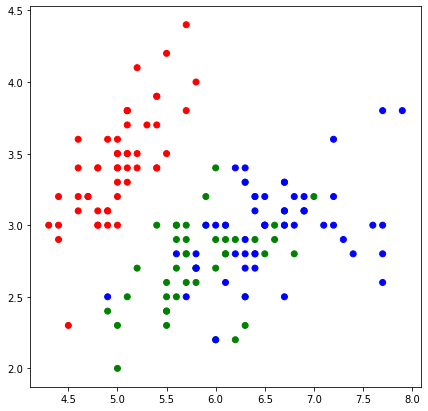

In [110]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

График распределения классов.

In [111]:
def get_graph(X_train, y_train, k, q, w):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, q, w)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [221]:
def accuracy_plot(plot):    
    plt.xlabel('k')
    plt.ylabel('accuracy')
    
    for plot in plot:
        y = graph[1]
        x = [i+1 for i in range(len(plot[1]))]
        plt.plot(x, y, label=f'k={plot[0]}')
        
    plt.legend(loc='lower right')
    plt.xlim(1, len(plot[1])+1)
    plt.show()

In [112]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритма при k=3 и k=5

In [166]:
k = 3
q = 2
w = None

y_pred = knn(X_train, y_train, X_test, k, w, q)

print(f'Точность алгоритма при k = {k} и w = {w}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 3 и w = None: 0.733


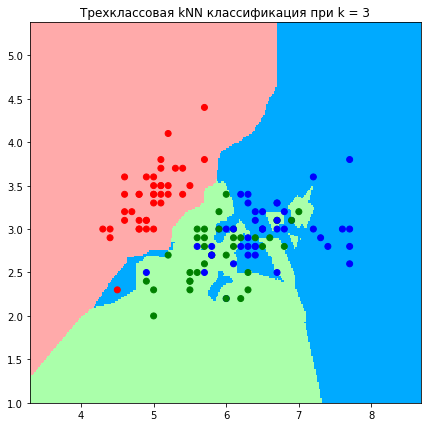

In [167]:
get_graph(X_train, y_train, k, w, q)

In [168]:
k = 5
q = 2
w = None

y_pred = knn(X_train, y_train, X_test, k, w, q)

print(f'Точность алгоритма при k = {k} и w = {w}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5 и w = None: 0.867


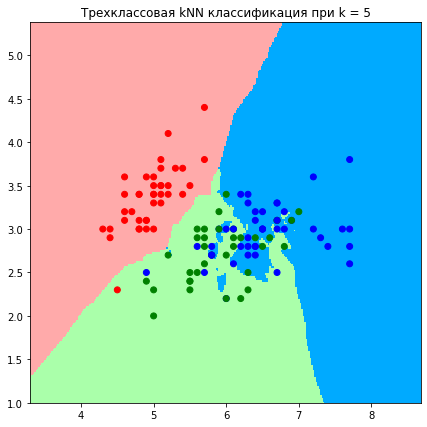

In [169]:
get_graph(X_train, y_train, k, w, q)

Повторим процедуру, но уже с добавлением весов в зависимости от номера соседа.

In [170]:
k = 3
q = 2
w = 'nn_weight'

y_pred = knn(X_train, y_train, X_test, k, w, q)

print(f'Точность алгоритма при k = {k} и w = {w}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 3 и w = nn_weight: 0.767


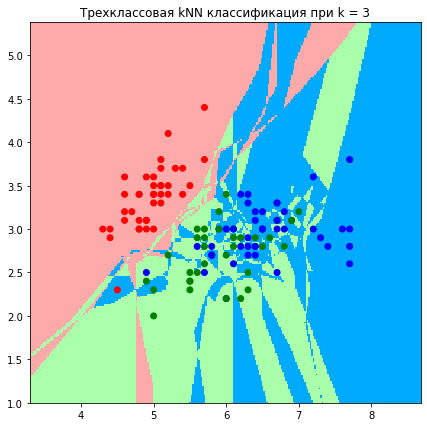

In [171]:
get_graph(X_train, y_train, k, w, q)

In [172]:
k = 5
q = 2
w = 'nn_weight'

y_pred = knn(X_train, y_train, X_test, k, w, q)

print(f'Точность алгоритма при k = {k} и w = {w}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5 и w = nn_weight: 0.800


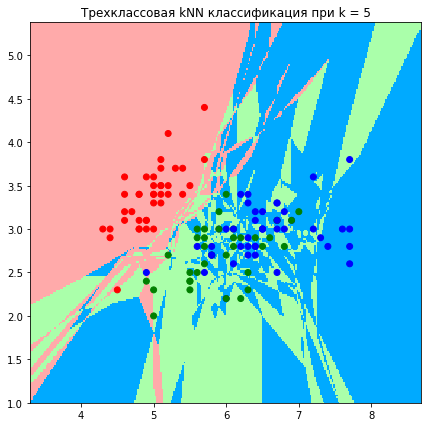

In [173]:
get_graph(X_train, y_train, k, w, q)

Тоже самое, только с добавлением весов в зависимости от расстояния до соседа.

In [183]:
k = 3
q = 2
w = 'n_dist_weight'

y_pred = knn(X_train, y_train, X_test, k, w, q)

print(f'Точность алгоритма при k = {k} и w = {w}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 3 и w = n_dist_weight: 0.733


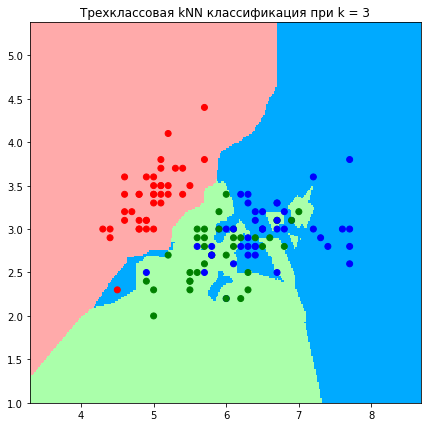

In [184]:
get_graph(X_train, y_train, k, w, q)

In [185]:
k = 5
q = 2
w = 'n_dist_weight'

y_pred = knn(X_train, y_train, X_test, k, w, q)

print(f'Точность алгоритма при k = {k} и w = {w}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5 и w = n_dist_weight: 0.867


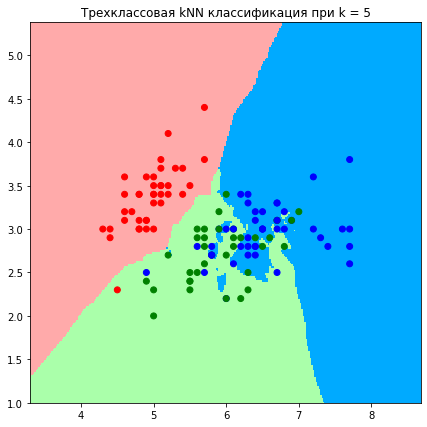

In [186]:
get_graph(X_train, y_train, k, w, q)

Наиболее сложная разделяющая гиперплоскость получилась при установке расчёта весов в зависимости от номера соседа. При двух
остальных вариантах разделяющая гиперплоскость проще, причём максимально простая гиперплоскость получилась для пяти соседей.

Попробуем настроить оптимальное число соседей.

In [250]:
neighbours = [i for i in range(1, 8)]
q = 2
w = 'n_dist_weight'

errors = []

for k in neighbours:
    y_pred = knn(X_train, y_train, X_test, k, w, q)
    errors.append(accuracy(y_pred, y_test))

In [253]:
print(f'Максимальное значение accuracy = {np.max(errors)} наблюдается при k = {errors.index(np.max(errors))+1}')

Максимальное значение accuracy = 0.8666666666666667 наблюдается при k = 5
